In [1]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.preprocessing.text import Tokenizer     # pip install tokenizer
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import sqlite3

Using TensorFlow backend.


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 140000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (140000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

<h2>#  [2] Exploratory Data Analysis</h2>

<h2>## [2.1] Data Cleaning: Deduplication</h2>

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(118907, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.93357142857143

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

Observation(s):

1. I have keep only those values whose HelpfulnessNumerator <= HelpfulnessDenominator.

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(118905, 10)


1    99869
0    19036
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_118904 = final['Text'].values[118904]
print(sent_118904)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.strongly recommend


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

Purchased this product at a local store in NY and my kids and i love it Its a quick easy meal You can put in a toaster oven on toast for 6 min and its ready to eat br strongly recommend


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

Observation(s):

1. Here we are having set of stopwords.
2. Here so many unused word in the stopwords.
3. stopwords are words which contain a dictionary of unused words.
4. If we are removing stopwordsthen our Bag of Words is much smaller and meaningful vector.

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [01:21<00:00, 1450.18it/s]


In [23]:
preprocessed_reviews[118904]

'purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend'

In [24]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
final['CleanedText']=final['CleanedText']
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (118905, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138687,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,summary young boy describes usefulness chicken...


Observation(s):

1. Here processed review can be seen in the CleanedText Column.
2. We will use it for future observation.
3. we are having 118905 matrix of features.

# Time Based Splitting

In [25]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 20K datapoints

# We will collect different 20K rows without repetition from time_sorted_data dataframe
final_20 = time_sorted_data.take(np.random.permutation(len(final))[:70000])
print(final_20.shape)
final_20.head(3)

(70000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
12820,13986,B000FKEWRM,A2MB5XC5QP3WBW,"Ricky N. ""Ricky C. Nelson""",3,4,1,1203465600,Maxwell House Filter Packs,Maxwell House has a winner with these filter p...,maxwell house winner filter packs leave home e...
70380,76559,B0049ULB78,A1QI6WTAUB6L6S,MP,0,0,1,1342915200,Dark Magic is a great cup of coffee,I am just 1 week into owning my Kuerig B60 and...,week owning kuerig sample pack brewed coffee g...
1694,1836,B001RVFDOO,A32G4AR56VP4YN,Michael J. Casteel,1,10,0,1327622400,Awful,I was at a charity fund raising event where th...,charity fund raising event handing seemed pret...


Observation(s):
1. Time based splitting is better than random splitting.
2. In time based splitting we sort our data in ascending order.
3. In TIme based splitting we get better accuracy than random splitting.

In [26]:
# sample dataset 
final_20['Score'].value_counts()

1    58885
0    11115
Name: Score, dtype: int64

In [27]:
# Original dataset
final['Score'].value_counts()

1    99869
0    19036
Name: Score, dtype: int64

In [28]:
# Ratio of positive reviews to negative reviews in Sample Dataset
len(final_20[final_20['Score'] == 1])/len(final_20[final_20['Score'] == 0])

5.297795771479982

In [29]:
# Ratio of positive reviews to negative reviews in Original Dataset
len(final[final['Score'] == 1])/len(final[final['Score'] == 0])

5.246322756881698

In [30]:
# final_20 datapoints which will use to train model
X = final_20['CleanedText'].values
print("shape of X:", X.shape)

shape of X: (70000,)


In [31]:
# class label
y = final_20['Score'].values
print("shape of y:", y.shape)

shape of y: (70000,)


<h2>Getting the vocabulary of all the words</h2>



In [32]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

X = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# Finding all words in the vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

vocabulary = tokenizer.word_index()
print('No. of words in the Vocabulary : ',len(vocabulary))

No. of words in the Vocabulary :  49863


In [33]:
# Storing all words in the dictionary (words as keys and index as values)
corpus = dict()
ind = 0
for sent in X:
  for word in sent.split():
    corpus.setdefault(word,[])
    corpus[word].append(ind)
    ind += 1

<h2>Getting frequency for each word in the vocabulary</h2>

In [34]:
# Getting frequency for each word of vocabulary and storing it in a list
freq = []
for w in vocabulary:
  freq.append(len(corpus[w]))

<h2>Getting Index for each word in the vocabulary</h2>

In [35]:
# Getting Index for each word in the vocabulary
# Sorting frequencies in decreasing order
inc_index =np.argsort(np.array(freq))[::-1]

In [36]:
# Allocating ranks to words of vocabulary in decreasing order of frequency and storing words in a dictionary
word_rank = dict()
rank = 1
for i in inc_index:
  word_rank[vocabulary[i]] = rank
  rank +=1

<h2>Converting this data as IMDB dataset</h2>

In [37]:
# Converting full data into imdb format
data = []
for sent in X:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)

In [40]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# Splitting the data set into training set and test set:
from sklearn.model_selection import train_test_split

# Splitting the data into 50-50 train_data and test_data
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(56000,) (56000,) (14000,) (14000,)


Observation(s):
    
1. I have split the dataset into training set and testing set.
2. Here 80% of the data used to train the model and 20% of the data used to test its performance of the test set.
3. Here i have 56000 points to train the model and 14000 points to test its performance on the test set.

In [45]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)

In [49]:
# truncate and/or pad input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(56000, 100)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
 60803  1223 22918 47584 62833 23675 44662 20734 41904 50838 45055 15407
 33510 24621   330  2571]


In [50]:
# this function is used draw Binary Crossentropy Loss VS No. of epochs plot
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('\nError Plot: Binary Crossentropy Loss VS Epochs')
  plt.legend()
  plt.grid()
  plt.show()

<h2>(1) RNN with 1 LSTM layer</h2>

In [51]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_1 = Sequential()

# Adding embedding
model_1.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding Dropout
model_1.add(Dropout(0.2))

# Adding first LSTM layer
model_1.add(LSTM(100))

# Adding Dropout
model_1.add(Dropout(0.2))

# Adding output layer
model_1.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_1.summary())

# Compiling the model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_1 = model_1.fit(X_train, Y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           2232096   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,285,397
Trainable params: 2,285,397
Non-trainable params: 0
_________________________________________________________________
None
Train on 56000 samples, validate on 14000 samples
Epoch 1/10
56000/56000 [==============================] - ETA: 9:52 - loss: 0

56000/56000 [==============================] - ETA: 2:22 - loss: 0.1536 - acc: 0.939 - ETA: 2:16 - loss: 0.1383 - acc: 0.950 - ETA: 2:12 - loss: 0.1340 - acc: 0.953 - ETA: 2:12 - loss: 0.1393 - acc: 0.947 - ETA: 2:12 - loss: 0.1374 - acc: 0.948 - ETA: 2:10 - loss: 0.1356 - acc: 0.950 - ETA: 2:08 - loss: 0.1339 - acc: 0.950 - ETA: 2:07 - loss: 0.1374 - acc: 0.949 - ETA: 2:06 - loss: 0.1387 - acc: 0.948 - ETA: 2:05 - loss: 0.1394 - acc: 0.946 - ETA: 2:04 - loss: 0.1397 - acc: 0.946 - ETA: 2:03 - loss: 0.1403 - acc: 0.946 - ETA: 2:01 - loss: 0.1407 - acc: 0.946 - ETA: 2:00 - loss: 0.1425 - acc: 0.945 - ETA: 2:00 - loss: 0.1409 - acc: 0.945 - ETA: 1:58 - loss: 0.1433 - acc: 0.944 - ETA: 1:57 - loss: 0.1422 - acc: 0.945 - ETA: 1:55 - loss: 0.1427 - acc: 0.945 - ETA: 1:54 - loss: 0.1415 - acc: 0.945 - ETA: 1:52 - loss: 0.1409 - acc: 0.945 - ETA: 1:51 - loss: 0.1418 - acc: 0.945 - ETA: 1:50 - loss: 0.1415 - acc: 0.945 - ETA: 1:49 - loss: 0.1434 - acc: 0.944 - ETA: 1:48 - loss: 0.1429 - acc: 0

56000/56000 [==============================] - ETA: 2:18 - loss: 0.1124 - acc: 0.960 - ETA: 2:14 - loss: 0.1178 - acc: 0.958 - ETA: 2:10 - loss: 0.1047 - acc: 0.962 - ETA: 2:09 - loss: 0.1023 - acc: 0.963 - ETA: 2:09 - loss: 0.0981 - acc: 0.965 - ETA: 2:09 - loss: 0.0979 - acc: 0.965 - ETA: 2:07 - loss: 0.1027 - acc: 0.963 - ETA: 2:05 - loss: 0.1021 - acc: 0.962 - ETA: 2:04 - loss: 0.1053 - acc: 0.961 - ETA: 2:03 - loss: 0.1071 - acc: 0.960 - ETA: 2:02 - loss: 0.1074 - acc: 0.960 - ETA: 2:01 - loss: 0.1068 - acc: 0.961 - ETA: 2:00 - loss: 0.1071 - acc: 0.961 - ETA: 1:58 - loss: 0.1071 - acc: 0.961 - ETA: 1:57 - loss: 0.1072 - acc: 0.961 - ETA: 1:56 - loss: 0.1091 - acc: 0.960 - ETA: 1:55 - loss: 0.1086 - acc: 0.960 - ETA: 1:54 - loss: 0.1068 - acc: 0.960 - ETA: 1:52 - loss: 0.1053 - acc: 0.961 - ETA: 1:51 - loss: 0.1044 - acc: 0.961 - ETA: 1:51 - loss: 0.1043 - acc: 0.961 - ETA: 1:49 - loss: 0.1048 - acc: 0.961 - ETA: 1:48 - loss: 0.1047 - acc: 0.961 - ETA: 1:47 - loss: 0.1031 - acc: 0

56000/56000 [==============================] - ETA: 2:25 - loss: 0.0881 - acc: 0.970 - ETA: 2:22 - loss: 0.0950 - acc: 0.963 - ETA: 2:17 - loss: 0.0995 - acc: 0.966 - ETA: 2:13 - loss: 0.0949 - acc: 0.968 - ETA: 2:11 - loss: 0.0927 - acc: 0.968 - ETA: 2:10 - loss: 0.0891 - acc: 0.969 - ETA: 2:10 - loss: 0.0895 - acc: 0.969 - ETA: 2:08 - loss: 0.0872 - acc: 0.970 - ETA: 2:06 - loss: 0.0910 - acc: 0.969 - ETA: 2:04 - loss: 0.0897 - acc: 0.970 - ETA: 2:03 - loss: 0.0906 - acc: 0.970 - ETA: 2:02 - loss: 0.0895 - acc: 0.970 - ETA: 2:01 - loss: 0.0887 - acc: 0.970 - ETA: 1:59 - loss: 0.0873 - acc: 0.971 - ETA: 1:58 - loss: 0.0865 - acc: 0.971 - ETA: 1:57 - loss: 0.0884 - acc: 0.970 - ETA: 1:56 - loss: 0.0901 - acc: 0.969 - ETA: 1:54 - loss: 0.0891 - acc: 0.970 - ETA: 1:53 - loss: 0.0889 - acc: 0.970 - ETA: 1:51 - loss: 0.0897 - acc: 0.969 - ETA: 1:50 - loss: 0.0889 - acc: 0.970 - ETA: 1:49 - loss: 0.0893 - acc: 0.970 - ETA: 1:47 - loss: 0.0888 - acc: 0.970 - ETA: 1:46 - loss: 0.0884 - acc: 0

56000/56000 [==============================] - ETA: 2:22 - loss: 0.0551 - acc: 0.982 - ETA: 2:19 - loss: 0.0579 - acc: 0.982 - ETA: 2:18 - loss: 0.0535 - acc: 0.981 - ETA: 2:15 - loss: 0.0488 - acc: 0.983 - ETA: 2:13 - loss: 0.0512 - acc: 0.982 - ETA: 2:11 - loss: 0.0551 - acc: 0.981 - ETA: 2:10 - loss: 0.0548 - acc: 0.982 - ETA: 2:10 - loss: 0.0553 - acc: 0.981 - ETA: 2:08 - loss: 0.0561 - acc: 0.981 - ETA: 2:07 - loss: 0.0569 - acc: 0.981 - ETA: 2:06 - loss: 0.0566 - acc: 0.982 - ETA: 2:05 - loss: 0.0587 - acc: 0.981 - ETA: 2:04 - loss: 0.0593 - acc: 0.981 - ETA: 2:02 - loss: 0.0605 - acc: 0.980 - ETA: 2:01 - loss: 0.0599 - acc: 0.980 - ETA: 1:59 - loss: 0.0621 - acc: 0.979 - ETA: 1:58 - loss: 0.0642 - acc: 0.979 - ETA: 1:57 - loss: 0.0638 - acc: 0.979 - ETA: 1:56 - loss: 0.0640 - acc: 0.979 - ETA: 1:54 - loss: 0.0632 - acc: 0.979 - ETA: 1:53 - loss: 0.0637 - acc: 0.979 - ETA: 1:52 - loss: 0.0631 - acc: 0.980 - ETA: 1:51 - loss: 0.0636 - acc: 0.979 - ETA: 1:49 - loss: 0.0647 - acc: 0

Accuracy: 90.26%


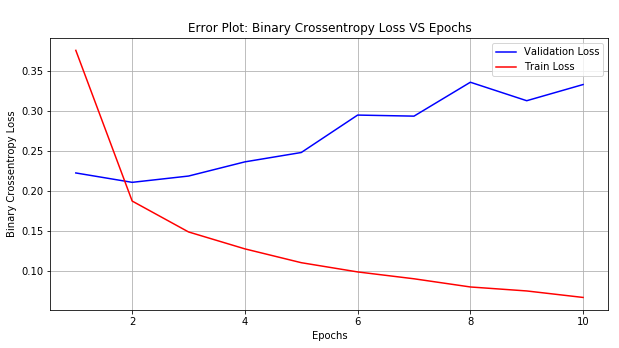

In [52]:
# Final evaluation of the model
scores = model_1.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_1_test = scores[1]
model_1_train = max(history_1.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_1.history['val_loss']
# Training loss
ty = history_1.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

<h2>(2). RNN with 2 LSTM layers</h2>

In [54]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_2 = Sequential()

# Adding embedding
model_2.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_2.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding second LSTM layer
model_2.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))

# Adding output layer
model_2.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_2.summary())

# Compiling the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_2 = model_2.fit(X_train, Y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           2232096   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 100)          53200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,365,797
Trainable params: 2,365,797
Non-trainable params: 0
_________________________________________________________________
None
Train on 56000 samples, validate on 14000 samples
Epoch 1/10
56000/56000 [==============================] - ETA: 13:04 - loss: 0.6932 - acc: 0.50 - ETA: 10:05 - loss: 0.6907 - acc: 0.67 - ETA: 9:04 - loss: 0.6872 - acc: 0.7318 - ETA: 8:17 - loss: 0.6829 - acc

56000/56000 [==============================] - ETA: 7:49 - loss: 0.1654 - acc: 0.949 - ETA: 7:38 - loss: 0.1709 - acc: 0.938 - ETA: 7:27 - loss: 0.1682 - acc: 0.940 - ETA: 7:19 - loss: 0.1661 - acc: 0.939 - ETA: 7:12 - loss: 0.1719 - acc: 0.935 - ETA: 7:08 - loss: 0.1734 - acc: 0.934 - ETA: 7:03 - loss: 0.1696 - acc: 0.935 - ETA: 6:57 - loss: 0.1662 - acc: 0.937 - ETA: 6:51 - loss: 0.1683 - acc: 0.935 - ETA: 6:46 - loss: 0.1707 - acc: 0.934 - ETA: 6:42 - loss: 0.1711 - acc: 0.934 - ETA: 6:38 - loss: 0.1706 - acc: 0.934 - ETA: 6:33 - loss: 0.1696 - acc: 0.935 - ETA: 6:29 - loss: 0.1671 - acc: 0.936 - ETA: 6:26 - loss: 0.1665 - acc: 0.937 - ETA: 6:22 - loss: 0.1708 - acc: 0.935 - ETA: 6:18 - loss: 0.1705 - acc: 0.935 - ETA: 6:15 - loss: 0.1712 - acc: 0.934 - ETA: 6:11 - loss: 0.1694 - acc: 0.935 - ETA: 6:08 - loss: 0.1704 - acc: 0.934 - ETA: 6:04 - loss: 0.1709 - acc: 0.935 - ETA: 6:00 - loss: 0.1713 - acc: 0.934 - ETA: 5:56 - loss: 0.1732 - acc: 0.934 - ETA: 5:53 - loss: 0.1724 - acc: 0

56000/56000 [==============================] - ETA: 10:07 - loss: 0.1110 - acc: 0.95 - ETA: 8:50 - loss: 0.1145 - acc: 0.9551 - ETA: 8:20 - loss: 0.1278 - acc: 0.951 - ETA: 8:04 - loss: 0.1320 - acc: 0.948 - ETA: 7:51 - loss: 0.1301 - acc: 0.950 - ETA: 7:42 - loss: 0.1297 - acc: 0.948 - ETA: 7:31 - loss: 0.1369 - acc: 0.947 - ETA: 7:23 - loss: 0.1358 - acc: 0.949 - ETA: 7:15 - loss: 0.1342 - acc: 0.951 - ETA: 7:09 - loss: 0.1331 - acc: 0.950 - ETA: 7:03 - loss: 0.1309 - acc: 0.951 - ETA: 6:56 - loss: 0.1277 - acc: 0.953 - ETA: 6:51 - loss: 0.1259 - acc: 0.954 - ETA: 6:45 - loss: 0.1268 - acc: 0.953 - ETA: 6:40 - loss: 0.1260 - acc: 0.953 - ETA: 6:35 - loss: 0.1256 - acc: 0.953 - ETA: 6:30 - loss: 0.1242 - acc: 0.953 - ETA: 6:27 - loss: 0.1242 - acc: 0.953 - ETA: 6:22 - loss: 0.1241 - acc: 0.953 - ETA: 6:26 - loss: 0.1258 - acc: 0.953 - ETA: 6:39 - loss: 0.1256 - acc: 0.953 - ETA: 6:42 - loss: 0.1267 - acc: 0.953 - ETA: 6:40 - loss: 0.1273 - acc: 0.953 - ETA: 6:36 - loss: 0.1282 - acc: 

56000/56000 [==============================] - ETA: 8:17 - loss: 0.0999 - acc: 0.962 - ETA: 7:59 - loss: 0.1042 - acc: 0.963 - ETA: 7:45 - loss: 0.1045 - acc: 0.966 - ETA: 7:55 - loss: 0.1019 - acc: 0.966 - ETA: 7:56 - loss: 0.1052 - acc: 0.964 - ETA: 7:58 - loss: 0.1033 - acc: 0.963 - ETA: 7:54 - loss: 0.1033 - acc: 0.963 - ETA: 7:45 - loss: 0.1013 - acc: 0.964 - ETA: 7:38 - loss: 0.1019 - acc: 0.963 - ETA: 7:31 - loss: 0.1008 - acc: 0.963 - ETA: 7:25 - loss: 0.0995 - acc: 0.964 - ETA: 7:18 - loss: 0.0994 - acc: 0.964 - ETA: 7:12 - loss: 0.0978 - acc: 0.964 - ETA: 7:05 - loss: 0.0981 - acc: 0.964 - ETA: 6:59 - loss: 0.0983 - acc: 0.963 - ETA: 6:53 - loss: 0.0989 - acc: 0.963 - ETA: 6:47 - loss: 0.1006 - acc: 0.963 - ETA: 6:41 - loss: 0.1012 - acc: 0.963 - ETA: 6:36 - loss: 0.1014 - acc: 0.963 - ETA: 6:32 - loss: 0.1000 - acc: 0.964 - ETA: 6:31 - loss: 0.0996 - acc: 0.964 - ETA: 6:26 - loss: 0.0987 - acc: 0.964 - ETA: 6:21 - loss: 0.0981 - acc: 0.965 - ETA: 6:19 - loss: 0.0981 - acc: 0

56000/56000 [==============================] - ETA: 9:07 - loss: 0.0748 - acc: 0.974 - ETA: 8:48 - loss: 0.0834 - acc: 0.967 - ETA: 8:20 - loss: 0.0915 - acc: 0.968 - ETA: 8:02 - loss: 0.0916 - acc: 0.968 - ETA: 7:49 - loss: 0.0901 - acc: 0.968 - ETA: 7:38 - loss: 0.0903 - acc: 0.968 - ETA: 7:28 - loss: 0.0858 - acc: 0.970 - ETA: 7:23 - loss: 0.0882 - acc: 0.971 - ETA: 7:16 - loss: 0.0910 - acc: 0.971 - ETA: 7:10 - loss: 0.0911 - acc: 0.971 - ETA: 7:04 - loss: 0.0911 - acc: 0.971 - ETA: 6:59 - loss: 0.0889 - acc: 0.971 - ETA: 6:53 - loss: 0.0898 - acc: 0.971 - ETA: 6:48 - loss: 0.0905 - acc: 0.971 - ETA: 6:42 - loss: 0.0886 - acc: 0.972 - ETA: 6:38 - loss: 0.0895 - acc: 0.971 - ETA: 6:33 - loss: 0.0872 - acc: 0.972 - ETA: 6:28 - loss: 0.0868 - acc: 0.972 - ETA: 6:24 - loss: 0.0861 - acc: 0.972 - ETA: 6:19 - loss: 0.0848 - acc: 0.973 - ETA: 6:14 - loss: 0.0847 - acc: 0.973 - ETA: 6:10 - loss: 0.0844 - acc: 0.972 - ETA: 6:06 - loss: 0.0854 - acc: 0.972 - ETA: 6:01 - loss: 0.0858 - acc: 0

Accuracy: 90.84%


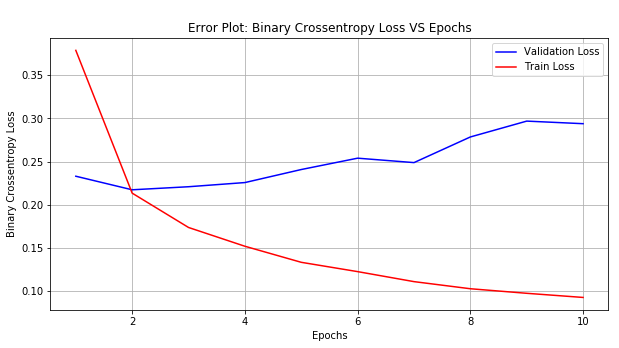

In [55]:
# Final evaluation of the model
scores = model_2.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_2_test = scores[1]
model_2_train = max(history_2.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_2.history['val_loss']
# Training loss
ty = history_2.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

<h2> [3] Conclusions</h2>

<h2>(a) Table (Different models with their train and test accuracies):</h2>

In [57]:
# Installing the library prettytable
!pip install prettytable

# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['RNN With 1 LSTM Layer','RNN With 2 LSTM Layers']

# Training accuracies
train_acc = [model_1_train,model_2_train]

# Test accuracies
test_acc = [model_1_test,model_2_test]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


+-------+------------------------+--------------------+--------------------+
| S.NO. |         MODEL          | Training Accuracy  |   Test Accuracy    |
+-------+------------------------+--------------------+--------------------+
|   1   | RNN With 1 LSTM Layer  |       0.977        | 0.9026428571428572 |
|   2   | RNN With 2 LSTM Layers | 0.9675000000681196 | 0.9084285714285715 |
+-------+------------------------+--------------------+--------------------+



<h2>(b). Procedure Followed :</h2>

Step 1: Load Amazon Fine Food Reviews dataset

Step 2: Perform text pre-processing

Step 3: Sort the dataset on the basis of time and after that find vocabulary for all the reviews in the dataset
    
Step 4: Now compute frequencies for each word of vocabulary
    
Step 5: Index each word in the decreasing order of frequencies (Word with max frequency will have rank 1 or index 1)

Step 6: Convert the dataset into imdb dataset format
    
Step 7: Split whole dataset for training set and test set
    
Step 8: Now pad or truncate each review intpo sequences of length 100
    
Step 9: Now implement RNN with 1 and 2 LSTM layers
    
Step 10: Finding accuracy for each
    
Step 11: Drawing Binary Crossentropy Loss VS No.of Epochs plot